In [16]:
import os
import cv2
import sys
import timm
import math
import glob
import torch
import random
import logging
import torchvision
import numpy as np
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms

from datetime import datetime
from torch.autograd import Variable
from PIL import Image
from functools import partial
from scipy.ndimage.morphology import distance_transform_edt
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, BCELoss
from scipy.ndimage.interpolation import zoom
from skimage.morphology import dilation, square, erosion

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from timm.models.registry import register_model

C:\Users\admin\AppData\Local\Temp\ipykernel_10808\2916948848.py:23: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt
C:\Users\admin\AppData\Local\Temp\ipykernel_10808\2916948848.py:25: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [17]:
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(profile="full")

# PVT

In [18]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class PyramidVisionTransformerImpr(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = 1
            #load_checkpoint(self, pretrained, map_location='cpu', strict=False, logger=logger)

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    # def _get_pos_embed(self, pos_embed, patch_embed, H, W):
    #     if H * W == self.patch_embed1.num_patches:
    #         return pos_embed
    #     else:
    #         return F.interpolate(
    #             pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
    #             size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

        # return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
class pvt_v2_b0(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)



@register_model
class pvt_v2_b1(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b2(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

C:\Users\admin\AppData\Local\Temp\ipykernel_10808\2497205739.py:374: UserWarning: Overwriting pvt_v2_b0 in registry with __main__.pvt_v2_b0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\admin\AppData\Local\Temp\ipykernel_10808\2497205739.py:384: UserWarning: Overwriting pvt_v2_b1 in registry with __main__.pvt_v2_b1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\admin\AppData\Local\Temp\ipykernel_10808\2497205739.py:392: UserWarning: Overwriting pvt_v2_b2 in registry with __main__.pvt_v2_b2. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [19]:
class PolypPVT(nn.Module):
    def __init__(self, channel=32):
        super(PolypPVT, self).__init__()

        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        path = './Unet-CLearning/weights/pvt_v2_b2.pth'
        save_model = torch.load(path)
        model_dict = self.backbone.state_dict()
        state_dict = {k: v for k, v in save_model.items() if k in model_dict.keys()}
        model_dict.update(state_dict)
        self.backbone.load_state_dict(model_dict)

    def forward(self, x):

        # backbone
        pvt = self.backbone(x)
        x1 = pvt[0]
        x2 = pvt[1]
        x3 = pvt[2]
        x4 = pvt[3]

        return [x1, x2, x3, x4]

# MSNET

In [20]:
class Decoder(nn.Module):
    def __init__(self, n_classes):
        super(Decoder, self).__init__()
        # Equalize feature dimensions
        self.x1_eq = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x2_eq = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x3_eq = nn.Sequential(nn.Conv2d(320, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x4_eq = nn.Sequential(nn.Conv2d(512, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b1_eq = nn.Sequential(nn.Conv2d(40, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b2_eq = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b3_eq = nn.Sequential(nn.Conv2d(176, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b4_eq = nn.Sequential(nn.Conv2d(512, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        # First layer
        self.x1_x2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b1_b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        # Second layer
        self.x3_x2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x3_x2_x1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b3_b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b3_b2_b1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        # Third layer
        self.x4_x3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x4_x3_x2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x4_x3_x2_x1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b4_b3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b4_b3_b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.b4_b3_b2_b1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        # Boundary layers
        self.q1_q2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.q2_q3 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.q3_q4 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        # Mask layers
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.up2 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.p3_inter1 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.p2_inter2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.p1_inter3 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        self.p4_q4 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.p3_q3 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.p2_q2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.p1_q1 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        self.output_m = nn.Sequential(nn.Conv2d(64, 1, kernel_size=3, padding=1))
        self.output_b = nn.Sequential(nn.Conv2d(64, 1, kernel_size=3, padding=1))

    def forward(self, x):
        x1, x2, x3, x4, b1, b2, b3, b4 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]

        '''
        x1 = torch.Size([8, 64, 56, 56])
        x2 = torch.Size([8, 128, 28, 28])
        x3 = torch.Size([8, 320, 14, 14])
        x4 = torch.Size([8, 512, 7, 7])
        b1 = torch.Size([8, 40, 56, 56])
        b2 = torch.Size([8, 64, 28, 28])
        b3 = torch.Size([8, 176, 14, 14])
        b4 = torch.Size([8, 512, 7, 7])
        '''

        # Equalization
        x1, x2, x3, x4, b1, b2, b3, b4 = self.x1_eq(x1), self.x2_eq(x2), self.x3_eq(x3), self.x4_eq(x4), self.b1_eq(b1), self.b2_eq(b2), self.b3_eq(b3), self.b4_eq(b4)

        # First layer
        p1 = self.x1_x2(F.upsample(x2,size=x1.size()[2:], mode='bilinear') + x1)
        q1 = self.b1_b2(F.upsample(b2,size=b1.size()[2:], mode='bilinear') + b1)

        # Second layer
        p2 = self.x3_x2(F.upsample(x3,size=x2.size()[2:], mode='bilinear') + x2)
        p1 = self.x3_x2_x1(F.upsample(p2,size=p1.size()[2:], mode='bilinear') + p1)
        q2 = self.b3_b2(F.upsample(b3,size=b2.size()[2:], mode='bilinear') + b2)
        q1 = self.b3_b2_b1(F.upsample(q2,size=q1.size()[2:], mode='bilinear') + q1)

        # Third layer
        p4 = x4
        p3 = self.x4_x3(F.upsample(p4,size=x3.size()[2:], mode='bilinear') + x3)
        p2 = self.x4_x3_x2(F.upsample(p3,size=p2.size()[2:], mode='bilinear') + p2)
        p1 = self.x4_x3_x2_x1(F.upsample(p2,size=p1.size()[2:], mode='bilinear') + p1)
        q4 = b4
        q3 = self.b4_b3(F.upsample(q4,size=b3.size()[2:], mode='bilinear') + b3)
        q2 = self.b4_b3_b2(F.upsample(q3,size=q2.size()[2:], mode='bilinear') + q2)
        q1 = self.b4_b3_b2_b1(F.upsample(q2,size=q1.size()[2:], mode='bilinear') + q1)

        # Final layer
        m_out = self.up(self.p4_q4(torch.cat((p4, q4), dim=1)))
        b_out = self.q1_q2(torch.cat((F.upsample(q4,size=q3.size()[2:], mode='bilinear'), q3), dim=1))

        inter_1 = self.p3_q3(torch.cat((p3, b_out), dim=1))
        m_out = self.up(self.p3_inter1(torch.cat((m_out, inter_1), dim=1)))
        b_out = self.q2_q3(torch.cat((F.upsample(b_out,size=q2.size()[2:], mode='bilinear'), q2), dim=1))

        inter_2 = self.p2_q2(torch.cat((p2, b_out), dim=1))
        m_out = self.up(self.p2_inter2(torch.cat((m_out, inter_2), dim=1)))
        b_out = self.q3_q4(torch.cat((F.upsample(b_out,size=q1.size()[2:], mode='bilinear'), q1), dim=1))

        inter_3 = self.p1_q1(torch.cat((p1, b_out), dim=1))
        m_out = self.p1_inter3(torch.cat((m_out, inter_3), dim=1))

        m_out = self.up2(self.output_m(m_out))
        b_out = self.up2(self.output_b(b_out))

        return m_out, b_out

        # return output, boundary

In [21]:
class DMSNet(nn.Module):
     def __init__(self, imgsize=(256,256), classes=1):
        super(DMSNet, self).__init__()
        self.imgsize = imgsize
        self.encoder_mask = PolypPVT()
        self.encoder_boundary = timm.create_model('efficientnet_b5', pretrained=True,features_only=True)
        self.decoder = Decoder(classes)


     def forward(self, x):
        mask_features = self.encoder_mask(x)        
        boundary_features = self.encoder_boundary(x)[1:]
        input = mask_features + boundary_features
        output, boundary = self.decoder(input)
        embedding = mask_features[-1]        
        embedding = F.interpolate(embedding, size=128, mode='bilinear', align_corners=False)

        return output, boundary, embedding


        # output, boundary, emb1 = self.decoder(encoded_output)
        # emb1 = F.interpolate(emb1, size=128, mode='bilinear', align_corners=False)

        # return output, boundary, emb1

In [22]:
# model = DMSNet()
# input = torch.rand((8,3,224,224))
# output = model(input)

# DATALODER

In [23]:
class CustomDataset(data.Dataset):
    """
    dataloader for polyp segmentation tasks
    """
    def __init__(self, image_root, gt_root, trainsize, augmentations):
        self.trainsize = trainsize
        self.augmentations = augmentations
        print(self.augmentations)
        self.images = glob.glob(os.path.join(image_root, '*'))
        self.gts = glob.glob(os.path.join(gt_root, '*'))
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.filter_files()
        self.size = len(self.images)
        if self.augmentations == 'True':
            print('Using RandomRotation, RandomFlip')
            self.img_transform = transforms.Compose([
                transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])
                # ,
                # transforms.Normalize([0.485, 0.456, 0.406],
                #                      [0.229, 0.224, 0.225])

            self.gt_transform = transforms.Compose([
                transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])

        else:
            print('no augmentation')
            self.img_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

            self.gt_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])
            
            self.r_lbl_transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor()])

    def __getitem__(self, index):

        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        cont_label = self.binary_loader(self.gts[index])

        gt_np = np.where(np.array(gt) > 0., 1, 0).astype(np.float32)
        ibdm = self.get_boundary(gt_np, 8)

        seed = np.random.randint(2147483647) # make a seed with numpy generator
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.img_transform is not None:
            image = self.img_transform(image)

        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.gt_transform is not None:
            gt = self.gt_transform(gt)
            cont_label = self.r_lbl_transform(cont_label)

        ibdm = zoom(ibdm, (self.trainsize / ibdm.shape[0], self.trainsize / ibdm.shape[1]), order=0)
        ibdm = torch.from_numpy(ibdm)


        # print(image.shape)
        # print(gt.shape)
        # print(ibdm.shape)

        return image, gt, ibdm, cont_label

    def get_boundary(self, mask, factor):
        dilated_img = dilation(mask, square(factor))
        erosion_img = erosion(mask, square(factor))
        final_img = dilated_img - erosion_img
        return final_img


    def filter_files(self):
        assert len(self.images) == len(self.gts)
        images = []
        gts = []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images = images
        self.gts = gts

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            # return img.convert('1')
            return img.convert('L')

    def resize(self, img, gt):
        assert img.size == gt.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST)
        else:
            return img, gt

    def __len__(self):
        return self.size


def get_loader(image_root, gt_root, batchsize, trainsize, shuffle=True, num_workers=0, pin_memory=True, augmentation=False):

    dataset = CustomDataset(image_root, gt_root, trainsize, augmentation)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader

# UTILS


In [24]:
class SyncFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, tensor):
        ctx.batch_size = tensor.shape[0]

        gathered_tensor = [torch.zeros_like(tensor) for _ in range(torch.distributed.get_world_size())]

        torch.distributed.all_gather(gathered_tensor, tensor)
        gathered_tensor = torch.cat(gathered_tensor, 0)

        return gathered_tensor

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        torch.distributed.all_reduce(grad_input, op=torch.distributed.ReduceOp.SUM, async_op=False)

        idx_from = torch.distributed.get_rank() * ctx.batch_size
        idx_to = (torch.distributed.get_rank() + 1) * ctx.batch_size
        return grad_input[idx_from:idx_to]

class PixelwiseContrastiveLoss(torch.nn.Module):
    '''
    The Pixel wise Contrastive Loss
    '''
    def __init__(self,
                 neg_multiplier,
                 n_max_pos=128,
                 boundary_aware=False,
                 boundary_loc='both',
                 sampling_type='full',
                 temperature=0.1):
        super(PixelwiseContrastiveLoss, self).__init__()
        self.cosine = nn.CosineSimilarity(dim=-1, eps=1e-8)
        self.n_max_pos = n_max_pos
        self.n_max_neg = n_max_pos * neg_multiplier
        self.boundary_aware = boundary_aware
        self.boundary_loc = boundary_loc
        self.sampling_type = sampling_type # 'full', 'random', 'linear'
        self.temperature = temperature

    def extract_boundary(self, real_label, is_pos=True):
        if not is_pos:
            real_label = 1 - real_label

        gt_b = F.max_pool2d(1 - real_label, kernel_size=5, stride=1, padding=2)
        gt_b_in = 1 - gt_b
        gt_b -= 1 - real_label
        return gt_b, gt_b_in

    def sample_pixels(self, label, n):
        cand_pixels = torch.nonzero(label)
        sample_idx = torch.randperm(cand_pixels.shape[0])[:n]
        sample_pixels = cand_pixels[sample_idx]
        return sample_pixels

    def _sample_balance(self, cand_pixels, n):
        batch_idx = cand_pixels[:,0]
        bs = batch_idx.max() + 1
        n_per_sample = n // bs
        sample_idx = []
        accum = 0
        for b in range(bs):
            n_features = int((batch_idx == b).sum().cpu())
            temp_idx = np.random.permutation(n_features)[:n_per_sample] + accum
            sample_idx += temp_idx.tolist()
            accum += n_features
        return sample_idx

    def split_n(self, n, boundary_type, limit, split_param=None):
        if n < limit:
            valid_n = n
        else:
            valid_n = limit

        if boundary_type == 'full':
            return valid_n, n-valid_n
        elif boundary_type == 'exclude':
            return 0, valid_n
        elif boundary_type == 'random':
            n_bd = int(torch.rand(1) * valid_n)
            n_not_bd = valid_n - n_bd
            return n_bd, n_not_bd
        elif boundary_type == 'linear':
            current_epoch, max_epoch = split_param
            n_bd = int(current_epoch/max_epoch * valid_n)
            n_not_bd = valid_n - n_bd
            return n_bd, n_not_bd
        elif boundary_type == 'fixed':
            n_bd = int(0.2 * valid_n)
            n_not_bd = valid_n - n_bd
            return n_bd, n_not_bd

    def forward(self, predict_seg_map, real_label, split_param=None, vector="embedding"):
        if self.boundary_aware:
            if self.boundary_loc == 'pos':
                pos_b, pos_b_in = self.extract_boundary(real_label)
                n_pos_bd, n_pos_not_bd = self.split_n(self.n_max_pos,
                                                      self.sampling_type,
                                                      limit=pos_b.sum(),
                                                      split_param=split_param)
                neg_b, neg_b_in = 1-real_label, 1-real_label
                n_neg_bd, n_neg_not_bd = 0, self.n_max_neg
            elif self.boundary_loc == 'neg':
                neg_b, neg_b_in = self.extract_boundary(real_label, is_pos=False)
                n_neg_bd, n_neg_not_bd = self.split_n(self.n_max_neg,
                                                      self.sampling_type,
                                                      limit=neg_b.sum(),
                                                      split_param=split_param)
                pos_b, pos_b_in = real_label, real_label
                n_pos_bd, n_pos_not_bd = 0, self.n_max_pos
            elif self.boundary_loc == 'both':
                pos_b, pos_b_in = self.extract_boundary(real_label)
                neg_b, neg_b_in = self.extract_boundary(real_label, is_pos=False)
                n_pos_bd, n_pos_not_bd = self.split_n(self.n_max_pos,
                                                      self.sampling_type,
                                                      limit=pos_b.sum(),
                                                      split_param=split_param)
                n_neg_bd = n_pos_bd
                n_neg_not_bd = self.n_max_neg - n_neg_bd
        else:
            pos_b, pos_b_in = real_label, real_label
            neg_b, neg_b_in = 1-real_label, 1-real_label
            n_pos_bd, n_pos_not_bd = 0, self.n_max_pos
            n_neg_bd, n_neg_not_bd = 0, self.n_max_neg

        # sample positive pixels
        pos_b_pixels = self.sample_pixels(pos_b, n_pos_bd)
        pos_b_in_pixels = self.sample_pixels(pos_b_in, n_pos_not_bd)
        pos_pixels = torch.cat((pos_b_pixels, pos_b_in_pixels), dim=0).detach()
        pos_pixels = tuple(pos_pixels.t())

        # sample negative pixels
        neg_b_pixels = self.sample_pixels(neg_b, n_neg_bd)
        neg_b_in_pixels = self.sample_pixels(neg_b_in, n_neg_not_bd)
        neg_pixels = torch.cat((neg_b_pixels, neg_b_in_pixels), dim=0).detach()
        neg_pixels = tuple(neg_pixels.t())

        if vector == "embedding" or vector == "first"  :
            positive_logits = predict_seg_map[pos_pixels[0], :, pos_pixels[2], pos_pixels[3]]
            negative_logits = predict_seg_map[neg_pixels[0], :, neg_pixels[2], neg_pixels[3]]
        elif vector == "second" :
            positive_logits = predict_seg_map[pos_pixels[0], :, pos_pixels[2], pos_pixels[3]]
            positive_logits = positive_logits[:int(len(positive_logits)/4)]

            negative_logits = predict_seg_map[neg_pixels[0], :, neg_pixels[2], neg_pixels[3]]
            negative_logits = negative_logits[:int(len(negative_logits)/4)]
        elif vector == "third" :
            positive_logits = predict_seg_map[pos_pixels[0], :, pos_pixels[2], pos_pixels[3]]
            positive_logits = positive_logits[:int(len(positive_logits)/16)]

            negative_logits = predict_seg_map[neg_pixels[0], :, neg_pixels[2], neg_pixels[3]]
            negative_logits = negative_logits[:int(len(negative_logits)/16)]
        elif vector == "four" :
            positive_logits = predict_seg_map[pos_pixels[0], :, pos_pixels[2], pos_pixels[3]]
            positive_logits = positive_logits[:int(len(positive_logits)/64)]

            negative_logits = predict_seg_map[neg_pixels[0], :, neg_pixels[2], neg_pixels[3]]
            negative_logits = negative_logits[:int(len(negative_logits)/64)]

        if torch.distributed.is_available() and torch.distributed.is_initialized():
            all_positive_logits = SyncFunction.apply(positive_logits)
            all_negative_logits = SyncFunction.apply(negative_logits)
        else:
            all_positive_logits = positive_logits
            all_negative_logits = negative_logits

        pos_nll = self._compute_loss(positive_logits,
                                     all_positive_logits,
                                     all_negative_logits)

        return pos_nll

    def _compute_loss(self, pos, all_pos, all_negs):
        positive_sim = self.cosine(pos.unsqueeze(1),
                                   all_pos.unsqueeze(0))
        exp_positive_sim = torch.exp(positive_sim/self.temperature)
        off_diagonal = torch.ones(exp_positive_sim.shape).type_as(exp_positive_sim)
        off_diagonal = off_diagonal.fill_diagonal_(0.0)
        exp_positive_sim = exp_positive_sim * off_diagonal
        positive_row_sum = torch.sum(exp_positive_sim, dim=1)

        negative_sim = self.cosine(pos.unsqueeze(1),
                                   all_negs.unsqueeze(0))
        exp_negative_sim = torch.exp(negative_sim/self.temperature)
        negative_row_sum = torch.sum(exp_negative_sim, dim=1)

        likelihood = positive_row_sum / (positive_row_sum + negative_row_sum)
        nll = -torch.log(likelihood).mean()

        return nll


def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    input = input.float()
    target = target.float()
    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

# class DiceLoss(nn.Module):
#     """Computes Dice Loss, which just 1 - DiceCoefficient described above.
#     Additionally allows per-class weights to be provided.
#     """

#     def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
#                  skip_last_target=False):
#         super(DiceLoss, self).__init__()
#         self.epsilon = epsilon
#         self.register_buffer('weight', weight)
#         self.ignore_index = ignore_index
#         # The output from the network during training is assumed to be un-normalized probabilities and we would
#         # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
#         # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
#         # However if one would like to apply Softmax in order to get the proper probability distribution from the
#         # output, just specify sigmoid_normalization=False.
#         if sigmoid_normalization:
#             self.normalization = nn.Sigmoid()
#         else:
#             self.normalization = nn.Softmax(dim=1)
#         # if True skip the last channel in the target
#         self.skip_last_target = skip_last_target

#     def forward(self, input, target):
#         # get probabilities from logits
#         input = self.normalization(input)
#         if self.weight is not None:
#             weight = Variable(self.weight, requires_grad=False)
#         else:
#             weight = None

#         if self.skip_last_target:
#             target = target[:, :-1, ...]

#         per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index,
#                                                     weight=weight)
#         # Average the Dice score across all channels/classes
#         return torch.mean(1. - per_channel_dice)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)


In [25]:
def clip_gradient(optimizer, grad_clip):
    """
    For calibrating misalignment gradient via cliping gradient technique
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def adjust_lr(optimizer, init_lr, epoch, decay_rate=0.1, decay_epoch=30):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay


class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.losses = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.losses.append(val)

    def show(self):
        return torch.mean(torch.stack(self.losses[np.maximum(len(self.losses)-self.num, 0):]))

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class BoundaryLoss(nn.Module):
    def __init__(self, thresh=0.002, min_ratio=0.1):
        super(BoundaryLoss, self).__init__()
        self.thresh = thresh
        self.min_ratio = min_ratio

    def forward(self, pred, target, smooth=1):
        pred = pred.view(-1)
        target = target.view(-1)
        loss = F.mse_loss(pred, target, reduction='none')
        _, index = loss.sort()  # 从小到大排序
        threshold_index = index[-round(self.min_ratio * len(index))]  # 找到min_kept数量的hardexample的阈值
        if loss[threshold_index] < self.thresh:  # 为了保证参与loss的比例不少于min_ratio
            self.thresh = loss[threshold_index].item()
        loss[loss < self.thresh] = 0
        loss = loss.mean()
        return loss

# MAIN

In [26]:
def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

def save_img(prediction, path, w_, h_):
    to_pil = transforms.ToPILImage()
    prediction = prediction.sigmoid()
    prediction = to_pil(prediction.data.squeeze(0).cpu())
    prediction = prediction.resize((w_, h_), Image.BILINEAR)
    prediction.save(path)

def check_positives(arr):
    # print(arr.shape)
    pos = 0
    for i in range(arr.shape[2]):
        for j in range(arr.shape[3]):
           if (arr[0][0][i][j] > 0):
               pos += 1
    return pos

In [27]:
all_loss = []

In [28]:
def train(train_loader, model, optimizer, epoch):
    global all_loss
    train_save = './saved_models/'
    ce_loss = BCELoss()
    dice_loss = DiceLoss()
    b_loss = BoundaryLoss()
    cont_loss = PixelwiseContrastiveLoss(neg_multiplier = 1,
                                         n_max_pos = 128,
                                         boundary_aware=False,
                                         boundary_loc='both',
                                         sampling_type='full'
                                        )

    model.train()
    global best

    loss_dice_record = AvgMeter()
    loss_boundary_record = AvgMeter()
    loss_ce_record = AvgMeter()
    loss_emb_record = AvgMeter()
    total_loss = AvgMeter()

    for i, pack in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        # ---- data prepare ----
        images, gts, ibdm, resized_label = pack
        images = Variable(images).cuda()
        gts = Variable(gts).cuda()
        ibdm = Variable(ibdm).cuda()
        resized_label = Variable(resized_label).cuda()

        output, boundary, emb = model(images)
        output = output.sigmoid()
        boundary = boundary.sigmoid()

        loss_boundary = b_loss(boundary, ibdm)
        loss_ce = ce_loss(output, gts)
        loss_dice = dice_loss(output, gts)
        loss_emb = cont_loss(emb, resized_label,
                                   split_param=(epoch, 50))

        loss = 0.5 * loss_dice + 0.5 * loss_ce + loss_boundary + loss_emb
        print('CE LOSS : {}, DICE LOSS : {}, BOUNDARY LOSS : {}, PCL LOSS : {}, TOTAL LOSS : {}'.format(loss_ce, loss_dice, loss_boundary, loss_emb, loss))
        # ---- backward ----
        loss.backward()
        clip_gradient(optimizer, 0.5)
        optimizer.step()
        # ---- recording loss ----
        total_loss.update(loss.data, 16)
        loss_dice_record.update(loss_dice.data, 16)
        loss_ce_record.update(loss_ce.data, 16)
        loss_boundary_record.update(loss_boundary.data, 16)
        loss_emb_record.update(loss_emb.data, 16)
        # ---- train visualization ----
        if i % 20 == 0 or i == total_step:
            # save_img(output[0,0,:,:], os.path.join('/content/boundaries', 'boundary_'+str(epoch)+'.png'), 352, 352)
            print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                  ' lateral-5: {:0.4f}]'.
                  format(datetime.now(), epoch, 50, i, total_step,
                         total_loss.show()))
    # save model
    all_loss.append([total_loss.show(), loss_dice_record.show(), loss_ce_record.show(), loss_boundary_record.show(), loss_emb_record.show()])
    save_path = (train_save)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    torch.save(model.state_dict(), save_path +str(epoch)+ 'DMSNET_DFU_PCL.pth')
    # choose the best model

In [29]:
optimizer_choice = 'AdamW'
lr = 1e-4
batchsize = 16
trainsize = 224
augmentation = False
epoch = 50
n_classes = 1

In [30]:
model = DMSNet().cuda()
best = 0
params = model.parameters()

if optimizer_choice == 'AdamW':
    optimizer = torch.optim.AdamW(params, lr, weight_decay=1e-4)
else:
    optimizer = torch.optim.SGD(params, lr, weight_decay=1e-4, momentum=0.9)

image_root = './Unet-CLearning/data/Foot Ulcer Segmentation Challenge/train/images'
gt_root = './Unet-CLearning/data/Foot Ulcer Segmentation Challenge/train/labels'

train_loader = get_loader(image_root, gt_root, batchsize=batchsize, trainsize=trainsize,
                              augmentation=augmentation)
total_step = len(train_loader)

for epoch in range(1, epoch+1):
    adjust_lr(optimizer, lr, epoch, 0.1, 200)
    train(train_loader, model, optimizer, epoch)

model.safetensors: 100%|██████████| 122M/122M [00:02<00:00, 49.7MB/s] 
d:\torch_gpu\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


False
no augmentation


d:\torch_gpu\Lib\site-packages\torch\nn\functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


CE LOSS : 0.6601758599281311, DICE LOSS : 0.9772682785987854, BOUNDARY LOSS : 0.3466474413871765, PCL LOSS : 0.06627064943313599, TOTAL LOSS : 1.231640100479126
CE LOSS : 0.6368045210838318, DICE LOSS : 0.954311728477478, BOUNDARY LOSS : 0.3354373276233673, PCL LOSS : 0.10766211152076721, TOTAL LOSS : 1.2386574745178223
CE LOSS : 0.6193434000015259, DICE LOSS : 0.9589548707008362, BOUNDARY LOSS : 0.32660728693008423, PCL LOSS : 0.05586286634206772, TOTAL LOSS : 1.1716194152832031
CE LOSS : 0.6054605841636658, DICE LOSS : 0.9657266736030579, BOUNDARY LOSS : 0.3160007894039154, PCL LOSS : 0.029673775658011436, TOTAL LOSS : 1.1312682628631592
CE LOSS : 0.587873101234436, DICE LOSS : 0.9553292393684387, BOUNDARY LOSS : 0.30463677644729614, PCL LOSS : 0.033936891704797745, TOTAL LOSS : 1.1101747751235962
CE LOSS : 0.571483314037323, DICE LOSS : 0.9649532437324524, BOUNDARY LOSS : 0.28942927718162537, PCL LOSS : 0.06204048544168472, TOTAL LOSS : 1.1196880340576172
CE LOSS : 0.556793808937072

In [31]:
all_loss_total = [all_loss[i][0].item() for i in range(len(all_loss))]
all_loss_ce = [all_loss[i][1].item() for i in range(len(all_loss))]
all_loss_dice = [all_loss[i][2].item() for i in range(len(all_loss))]
all_loss_boundary = [all_loss[i][3].item() for i in range(len(all_loss))]

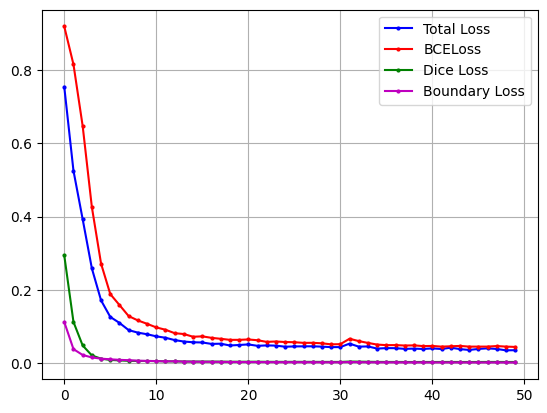

In [32]:
plt.plot(all_loss_total, linestyle='-', marker='o', color='b', ms=2, label='Total Loss')
plt.plot(all_loss_ce, linestyle='-', marker='o', color='r', ms=2, label='BCELoss')
plt.plot(all_loss_dice, linestyle='-', marker='o', color='g', ms=2, label='Dice Loss')
plt.plot(all_loss_boundary, linestyle='-', marker='o', color='m', ms=2, label='Boundary Loss')
plt.legend()
plt.grid(True)
plt.show()